# Singular Spectrum Analysis for NH Monthly Land Temperature

Singular Spectrum Analysis (SSA) is a powerful nonparametric method of analysis and forecasting of time series. It tries to overcome the problems of finite sample length and noisiness of sampled time series not by fitting an assumed model to the available series, but by using a data-adaptive basis set, instead of the fixed sine and cosine of the BT method.

The scope of applications of SSA is very wide, from non-parametric time series decomposition and filtration to parameter estimation and forecasting. One of the differences between SSA and the methods of traditional time series analysis is the fact that SSA and SSA-related methods can be applied to quite different and not conventional for classical time series analysis problems such as exploratory analysis for data-mining and parameter estimation in signal processing, among others. For a rigorous and advanced introduction to SSA, please refer to the review paper Ghil et al. (2002) “Advanced spectral methods for climatic time series”, Rev Geophys 40(1): 3.1–3.41. 

In this notebook, we take the datasets of GISTEMP Northern Hemisphere-mean as an example (from 1880 to present). The GISS Surface Temperature Analysis (GISTEMP) is an estimate of global surface temperature change (https://data.giss.nasa.gov/gistemp/). The data is updated around the middle of every month using current data files from NOAA GHCN v3 (meteorological stations), ERSST v5 (ocean areas), and SCAR (Antarctic stations), combined as described in our December 2010 publication (Hansen et al., 2010). The data are presented as anomalies, i.e. deviations from the corresponding 1951-1980 means.

There are many implementations of SSA such as R, Mathlab and Python. The Python package of [pyssa](https://github.com/aj-cloete/pySSA) is used In this notebook.

## 1. Load all needed libraries

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np

from mySSA import mySSA # private lib
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

## 2. Read data

In [2]:
df = pd.read_csv(r'data\NH.Ts.csv', parse_dates=True, index_col='Year', skiprows=1)
df = df['1881':'2016']
df.drop(['SON', 'MAM', 'DJF', 'JJA', 'J-D', 'D-N'], axis=1, inplace=True)
df1 = df.apply(pd.to_numeric, errors='coerce')
df1.tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2012-01-01,0.79,0.75,0.98,1.35,1.24,1.16,0.99,0.95,1.05,1.09,1.15,0.63
2013-01-01,1.16,0.95,1.11,0.86,0.92,0.95,0.84,0.81,0.81,1.03,1.20,1.01
2014-01-01,1.30,0.98,1.44,1.39,1.15,1.00,0.95,0.96,0.93,1.17,1.02,1.43
2015-01-01,1.42,1.36,1.58,1.24,1.17,1.21,1.03,1.12,1.22,1.39,1.58,1.91
2016-01-01,1.95,2.49,2.44,1.98,1.40,1.37,1.30,1.40,1.45,1.36,1.37,1.40


### Convert data to monthly time series

In [3]:
tmp = df1.values.astype(np.float)
tmp = tmp.reshape(tmp.shape[0]*12,1)
print(tmp.shape)

ds = pd.date_range(start='1/1/1881', end='12/1/2016', freq='MS') 
ts = pd.DataFrame(tmp, columns=['TEMP'])  
ts = ts.set_index(ds)

(1632, 1)


### Have a quick plot

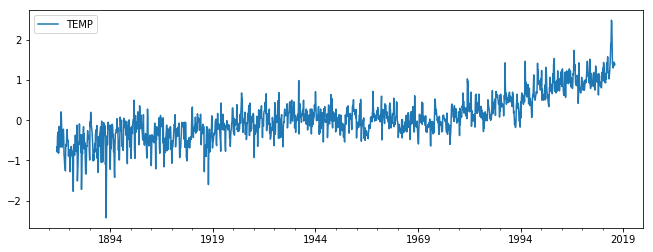

In [4]:
ts.plot()

## 3. Carry out SSA analysis

The general procedure in SSA is as follows:
1. **Embed** the time series by forming a Hankel matrix of lagged window (length K) vectors.
2. **Decompose** the embedded time series via Singular Value Decomposition
3. **Eigentripple Grouping** is the process of identifying eigenvalue-eigenvector pairs as *trend*, *seasonal* and *noise*
4. **Reconstruct** the time series from the eigenvalue-eigenvector pairs identified as *trend* and *seasonal*.  This is done through a process called *diagonal averaging*.

Instantiate a ssa object with the time series

In [5]:
ssa = mySSA(ts)

In [6]:
K = 40
suspected_seasonality = 12

In [7]:
ssa.embed(embedding_dimension=40, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  36
Trajectory dimensions	: (36, 1597)
Complete dimension	: (36, 1597)
Missing dimension     	: (36, 0)


In [8]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 36
Dimension of projection space	: 36
Characteristic of projection	: 1.0


We can view the contribution of each of the signals (corresponding to each singular value) as follows:

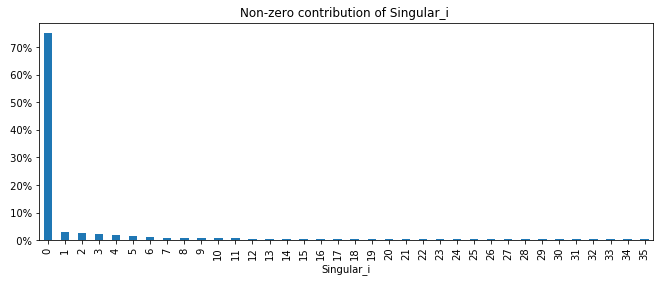

In [9]:
ssa.view_s_contributions()

From the above we can see that most of the variation is contained in the first signal (corresponding to the first singular vector).  The scale in the image above makes it difficult to see what's going on with the remaining singular values.  

Pass the argument  `adjust_scale=True` to see the eigenvalue groupings more clearly.  The scale on the y-axis is meaningless and is removed in this case.

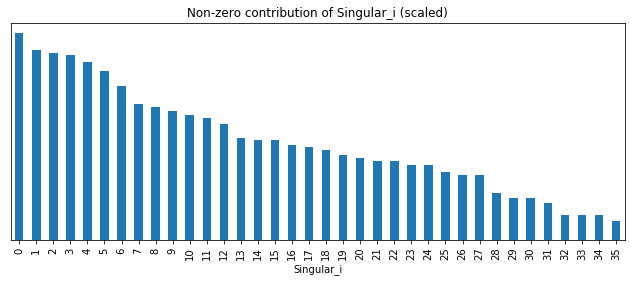

In [10]:
ssa.view_s_contributions(adjust_scale=True)

Now that we have the signal components (there are 15 additive components to the signal) we can loop over that range and look at each one individually.  We only look at the first 5 elements below:

*The additive signal elements are stored in the* `object.Xs` *dictionary.*

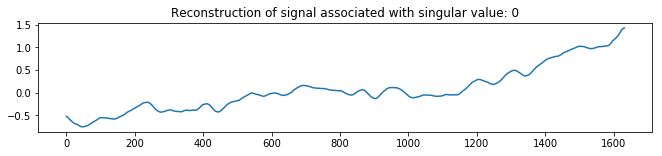

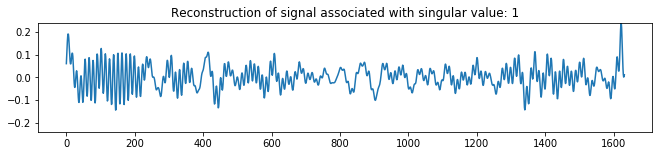

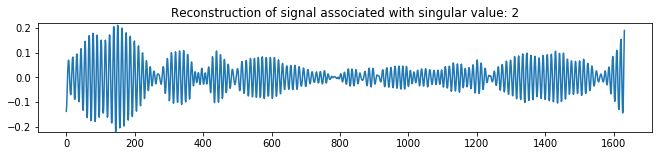

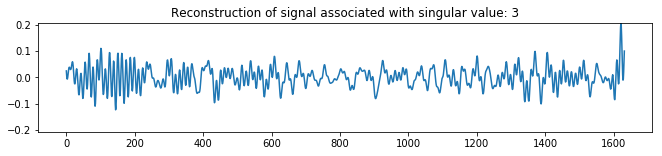

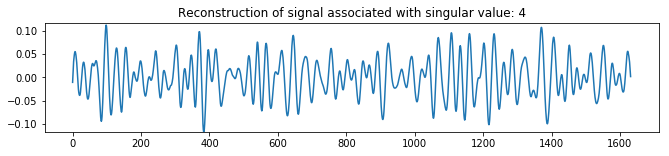

In [11]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

Let's see the result if we reconstruct the signal from these 5 streams.  We add the first 5 signals and pass the result to `object.view_reconstruction`.

In [12]:
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True, plot=False)

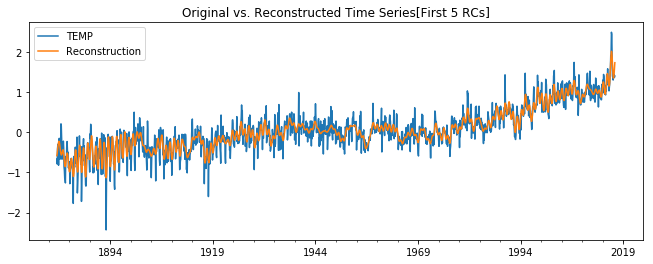

In [13]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series[First 5 RCs]');

That looks very reasonable! We can get closer to the original series by adding additional signals from the remaining singular values.  Let's use the first 15 singular values:

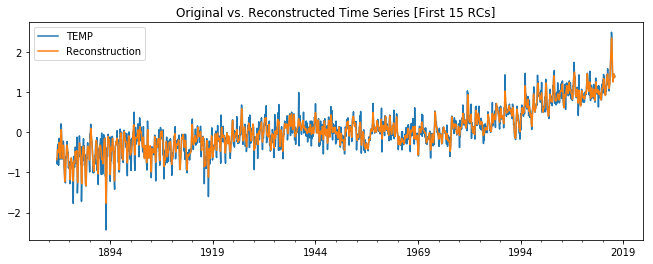

In [14]:
streams15 = [i for i in range(15)]
reconstructed15 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams15], 
                                          names=streams15, return_df=True, plot=False)
ts_copy15 = ssa.ts.copy()
ts_copy15['Reconstruction'] = reconstructed15.Reconstruction.values
ts_copy15.plot(title='Original vs. Reconstructed Time Series [First 15 RCs]');

## 4. Forecast

To forecast using only some of the singular values, pass the list of singular value indices to be used to the `forecast_recurrent` method.

Take a forecast with 10 years ahead (i.e., 120 months) as an instance.

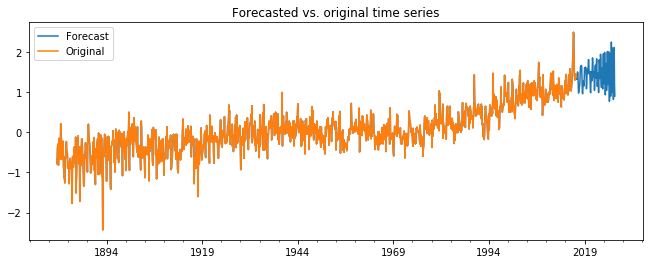

In [15]:
ssa.forecast_recurrent(steps_ahead=120, singular_values=streams15, plot=True)

## References

GISTEMP Team, 2017: GISS Surface Temperature Analysis (GISTEMP). NASA Goddard Institute for Space Studies. Dataset accessed 20YY-MM-DD at https://data.giss.nasa.gov/gistemp/.

Hansen, J., R. Ruedy, M. Sato, and K. Lo, 2010: Global surface temperature change, Rev. Geophys., 48, RG4004, doi:10.1029/2010RG000345.

Ghil M., R. M. Allen, M. D. Dettinger, K. Ide, D. Kondrashov, M. E. Mann, A. Robertson, A.Saunders, Y. Tian, F. Varadi, and P. Yiou, 2002: "Advanced spectral methods for climatic time series," Rev. Geophys.,40(1), pp. 3.1-3.41, 10.1029/2000RG000092.
Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010)

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37